In [1]:
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from gam_follow_up import config

In [2]:
def read_csvs(input_csvs):
    return pd.concat([pd.read_csv(fi) for fi in input_csvs])

In [3]:
def get_p_val(obs, rand):
    
    randoms = np.array(rand)
    
    p_high = 1.0 - (randoms > obs).mean()
    p_low = 1.0 - (randoms < obs).mean()

    return min((p_high, p_low))

In [4]:
def get_col(enrich_dict):
    
    if enrich_dict['sig']:
        if enrich_dict['ratio'] > 1:
            return 'red'
        else:
            return 'blue'
    else:
        return 'grey'

In [11]:
def process_results(results_df):

    results = {}

    feat_pairs = list(results_df.groupby(['class1', 'class2']).class2.count().index)

    for f1, f2 in feat_pairs:

        k1, k2 = sorted((f1, f2))

        results[(k1, k2)] = {}

        feat_analysis_df = results_df[(results_df.class1 == f1) &
                          (results_df.class2 == f2)]

        obs = np.array(feat_analysis_df.loc[
                               (feat_analysis_df.permuted == 'no'),
                               'count'])[0]

        results[(k1, k2)]['obs'] = obs

        rand = np.array(feat_analysis_df.loc[
                               (feat_analysis_df.permuted == 'yes'),
                               'count'])

        results[(k1, k2)]['est'] = rand.mean()

        results[(k1, k2)]['ratio'] = (obs / rand.mean())

        p_val = get_p_val(obs, rand)
        results[(k1, k2)]['sig'] = p_val < (0.05 / len(feat_pairs))
        results[(k1, k2)]['p-val'] = p_val

    return results   


In [6]:
def plot_enrichments(enrichment_results, keys_to_plot):
    sorted_keys = [t[0] for t in sorted([(k,v['ratio'])
                                         for k,v in enrichment_results.items()
                                         if (k[0] in keys_to_plot) and (k[1] in keys_to_plot)], key=lambda k:k[1])]
    vals = [enrichment_results[k]['ratio'] -1 for k in sorted_keys]
    cols=[get_col(enrichment_results[k]) for k in sorted_keys]

    plt.figure(figsize=(10,7))
    plt.barh(range(len(sorted_keys)), vals, color=cols)
    plt.yticks(np.arange(len(sorted_keys)) + 0.4, ['{0} / {1}'.format(*k) for k in sorted_keys])
    plt.xticks(plt.xticks()[0],plt.xticks()[0]+1)

# Combined dataset

In [8]:
input_csvs_combined = glob.glob(
    config.in_data_intermediate('slice-enrichments/1np_plus_4np/*.csv'))

In [12]:
res_combined = process_results(read_csvs(input_csvs_combined))

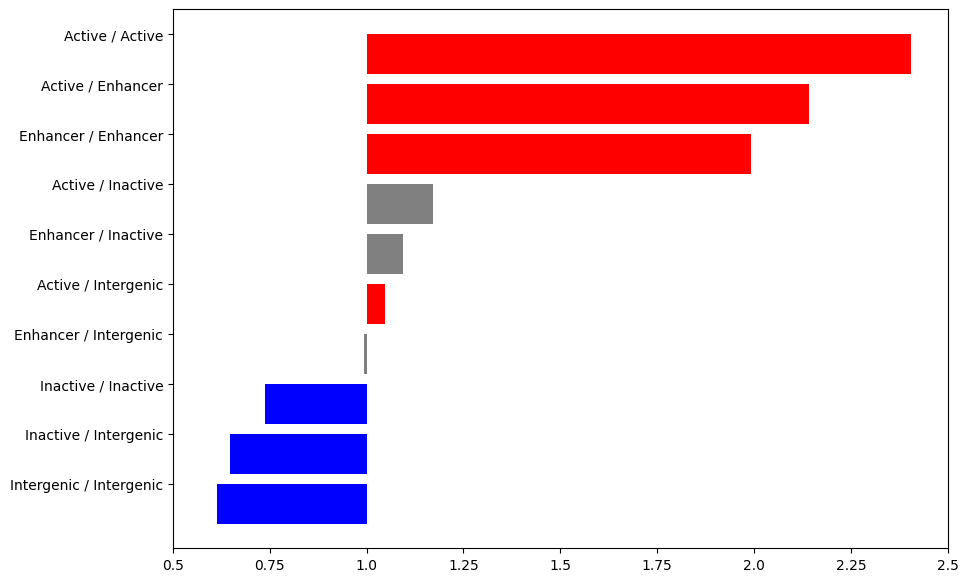

In [14]:
plot_enrichments(res_combined, ['Active', 'Enhancer', 'Inactive', 'Intergenic'])

# FDR-corrected results

In [20]:
input_csvs_fdr = glob.glob(
    config.in_data_intermediate('slice-enrichments/fdr-corrected/*.csv'))

In [21]:
input_df_fdr = read_csvs(input_csvs_fdr)

In [22]:
res_fdr = process_results(input_df_fdr)

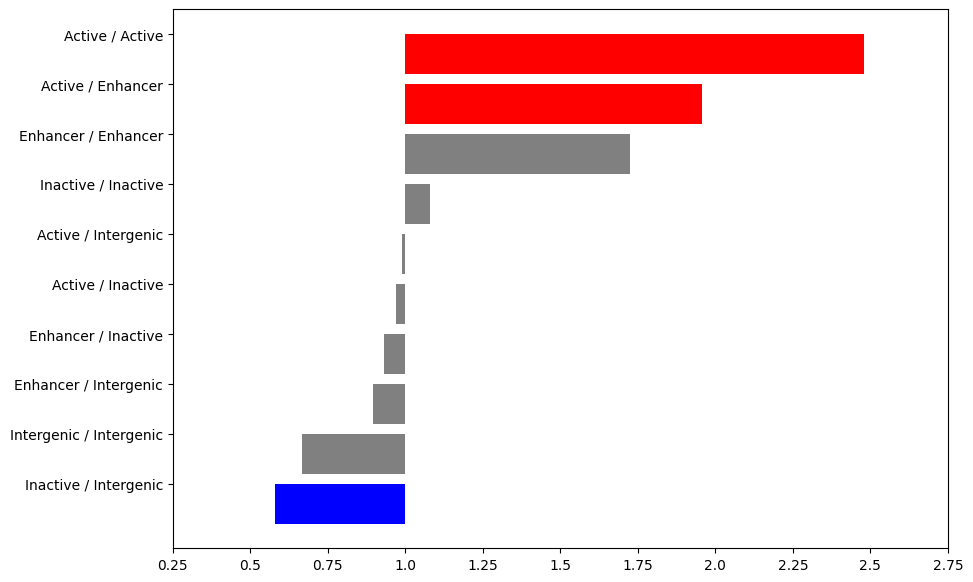

In [23]:
plot_enrichments(res_fdr, ['Active', 'Enhancer', 'Inactive', 'Intergenic'])